In [129]:
import pandas as pd
import numpy as np
import math
import copy
import itertools

# import models
from preprocessing import get_sessions, train_test_split, n_unique_queries
from RCM import RCM
from RCTR import RCTR
from DCTR import DCTR
from CM import CM
from DCM import DCM
from PBM import PBM
from UBM import UBM
from SDBN import SDBN

In [130]:
# function for the computation of the confidence interval
from scipy.stats import t
def closed_formula(m, s, len_, confidence=0.95):
    '''
    Function to compute a confidence interval by using the definition
    m = mean
    s = std
    '''
    dof = len_-1
    # compute the t value
    t_crit = np.abs(t.ppf((1-confidence)/2,dof))
    # compute the CI
    return [m-s*t_crit/np.sqrt(len_), m+s*t_crit/np.sqrt(len_)]

In [131]:
# as the previous one but with a different computation
def bootstrap(values, confidence=0.95):
    '''
    Function to compute a confidece interval by using the bootstrap method
    '''
    return np.percentile(values,[100*(1-confidence)/2,100*(1-(1-confidence)/2)])

Bootstraps gives an unbiased estimate, paying the cost of a computationally complex algorithm. As you can clearly see below, there is not a big difference between the two methods.

In [132]:
def print_estimation(model_, parameter, values):
    '''
    Function just to print results
    '''
    print("\033[1m"+"{} estimation: {}\n".format(parameter,model_.__class__.__name__))
    mean = values[1]
    std = values[2]
    len_ = values[3]
    print('\033[0m'+"Estimator (on the test set): {}".format(mean))
    ci = closed_formula(mean, std, len_)
    ci_boot = values[4]
    print("CI with the closed formula: {}".format(ci))
    print("CI with bootstrap: {}\n".format(ci_boot))
    #print("Test estimator: {}".format(np.mean(parameter_list_test)))
    print('-------------------------------------------------------')
    return 

In [133]:
import time
from tqdm import tqdm
def parameters_estimation(model_, verbose = True, n_sessions=100000, samples = 15):
    '''
    This function create a list (both for training and test sets because 
    I still don't know which one I should use), with the values of the loglikelihood and
    perplexity computed for different samples (default 15). 
    Each sample is a subset of clicklog with "n_sessions" sessions.
    
    It then compute the mean (that is the estimate of the population mean), and
    computes the confidence interval (both with the closed formula and the boostrap method)
    
    If verbose=True it prints results
    '''
    start, stop = 1, n_sessions
    parameter_list = []
    parameter2_list = []
    parameter2_ranklist = []
    time_list = []
    estimation = {}
    description="Processing {}".format(model_.__class__.__name__)
    for i in tqdm(range(samples), desc=description):
        sessions = get_sessions('Clicklog.txt', stop, start)
        train_sessions, test_sessions = train_test_split(sessions, 0.75)
        
        start_time = time.time()
        model = model_
        model.train(train_sessions)
        time_list.append(time.time() - start_time)
        
        parameter_list.append(model.log_likelihood(test_sessions))
        parameter2_list.append(model.perplexity(test_sessions))
        parameter2_ranklist.append(model.perplexity_per_rank(test_sessions))
        start += n_sessions
        stop += n_sessions
            
        
    estimation['Log-likelihood']=[parameter_list,
                                  np.mean(parameter_list),
                                  np.std(parameter_list),
                                  len(parameter_list),
                                  bootstrap(parameter_list)]
    estimation['Perplexity']=[parameter2_list,
                              np.mean(parameter2_list),
                              np.std(parameter2_list),
                              len(parameter2_list),
                              bootstrap(parameter2_list)]
                              #np.mean(parameter2_ranklist, axis=0)]
    estimation['Time']=[time_list,
                        np.mean(time_list),
                        np.std(time_list),
                        len(time_list),
                        bootstrap(time_list)]
    estimation['Perplexity per rank']=[parameter2_ranklist,
                                       np.mean(parameter2_ranklist, axis=0),
                                       np.std(parameter2_ranklist, axis=0),
                                       len(parameter2_ranklist),
                                       [bootstrap([i for i in np.array(parameter2_ranklist)[:,z]])[1]-bootstrap([i for i in np.array(parameter2_ranklist)[:,z]])[0] for z in range(10)]]
    
    if verbose:
        for parameter, values in estimation.items():
            print_estimation(model_, parameter, values)
        
    
    return estimation

In [134]:
rcm_estimators = parameters_estimation(RCM()) #example

Processing RCM: 100%|██████████| 15/15 [05:53<00:00, 23.56s/it]


Log-likelihood estimation: RCM

Estimator (on the test set): -0.42135824591636806
CI with the closed formula: [-0.42429361789478215, -0.41842287393795397]
CI with bootstrap: [-0.43073405 -0.41449664]

-------------------------------------------------------
Perplexity estimation: RCM

Estimator (on the test set): 1.7166685440173448
CI with the closed formula: [1.70618768645642, 1.7271494015782696]
CI with bootstrap: [1.68924104 1.74745431]

-------------------------------------------------------
Time estimation: RCM

Estimator (on the test set): 0.454217799504598
CI with the closed formula: [0.3881707646090803, 0.5202648344001157]
CI with bootstrap: [0.16819289 0.56595947]

-------------------------------------------------------
Perplexity per rank estimation: RCM

Estimator (on the test set): [5.11362594 1.68737585 1.45974621 1.3676124  1.31141798 1.27566824
 1.25440374 1.23399508 1.23008841 1.23275161]
CI with the closed formula: [array([5.02028794, 1.67869936, 1.45573579, 1.36379303,

In [135]:
def take_boot(where):
    return where[4][1]-where[4][0]

In [136]:
model_list = [RCM(), RCTR(), DCTR(), CM(), DCM(), PBM(), UBM(), SDBN()] #models!!

In [137]:
# lists to save values
list_names, list_log, list_perp, list_time = [], [], [], []
dict_perp_rank = {}
# to draw the confidence interval in the bar plot
list_log_boot, list_perp_boot, list_time_boot = [], [], []
dict_perprank_boot = {}

from tqdm.notebook import tqdm
print("Runned models:\n")
for model in model_list:
    estimators = parameters_estimation(model, verbose=False)
        
    list_names.append(model.__class__.__name__)
    #print("\t\t {} \u2713".format(model.__class__.__name__))
    list_log.append(estimators['Log-likelihood'][1])
    list_log_boot.append(take_boot(estimators['Log-likelihood']))
    list_perp.append(estimators['Perplexity'][1])
    list_perp_boot.append(take_boot(estimators['Perplexity']))
    list_time.append(estimators['Time'][1])
    list_time_boot.append(take_boot(estimators['Time']))
    dict_perp_rank[model.__class__.__name__] = estimators['Perplexity per rank'][1]
    dict_perprank_boot[model.__class__.__name__] = estimators['Perplexity per rank'][4]

Runned models:



Processing RCM:   0%|          | 0/15 [00:00<?, ?it/s]

Processing RCTR:   0%|          | 0/15 [00:00<?, ?it/s]

Processing DCTR:   0%|          | 0/15 [00:00<?, ?it/s]

Processing CM:   0%|          | 0/15 [00:00<?, ?it/s]

Processing DCM:   0%|          | 0/15 [00:00<?, ?it/s]

Processing PBM:   0%|          | 0/15 [00:00<?, ?it/s]

Processing UBM:   0%|          | 0/15 [00:00<?, ?it/s]

Processing SDBN:   0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
# dataframe with them all together

In [138]:
pd_parameters = pd.DataFrame({'Names': list_names, 'Loglike': list_log, 
              'Perplexity': list_perp, 'Time': list_time})
pd_parameters

,Names,Loglike,Perplexity,Time
0,RCM,-0.421358,1.716669,0.411567
1,RCTR,-0.308236,1.387819,2.110245
2,DCTR,-0.261053,1.310789,22.539181
3,CM,-0.292252,1.351409,21.399894
4,DCM,-0.261508,1.311111,42.377870
5,PBM,-0.254992,1.303039,663.380839
6,UBM,-0.240261,1.286096,2182.314747
7,SDBN,-0.255957,1.303559,108.801491


In [141]:
import matplotlib.pyplot as plt
def bar_plot(y, list_error, title):
    fig = plt.figure(figsize=(10, 7))
    plt.bar(pd_parameters['Names'], y, yerr=list_error, capsize=4)
    plt.title('{} values for different models'.format(title))
    plt.ylabel('{}'.format(title))
    plt.show()
    return

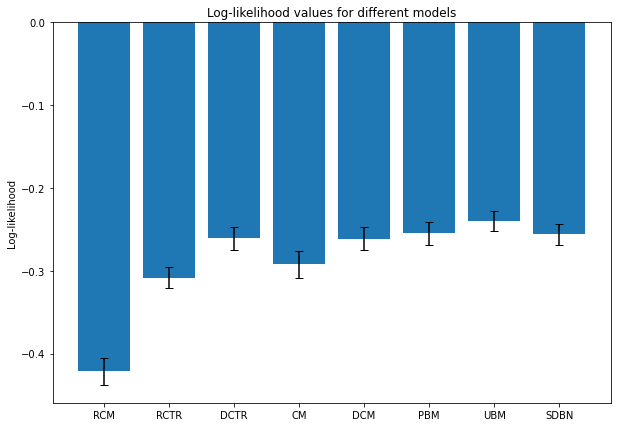

In [142]:
bar_plot(pd_parameters['Loglike'], list_log_boot, 'Log-likelihood') #100.000

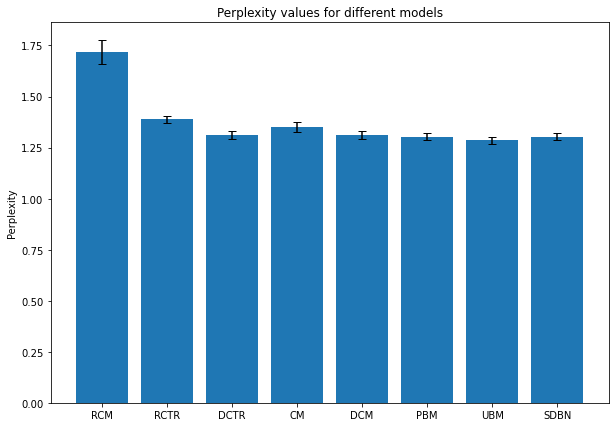

In [143]:
bar_plot(pd_parameters['Perplexity'], list_perp_boot, 'Perplexity') #100.000

In [161]:
# create a list of colors for the plot: necessary only if we plot the confidence interval too
from random import randint
colors = {}
i=0
for name in pd_parameters['Names']:
    colors[name] = '#%06X' % randint(0, 0xFFFFFF)
    i+=1
colors

{'RCM': '#640EBB',
 'RCTR': '#37A2AF',
 'DCTR': '#D0EA22',
 'CM': '#6CACED',
 'DCM': '#B3CD70',
 'PBM': '#0DBE7E',
 'UBM': '#E499A8',
 'SDBN': '#6E86EF'}

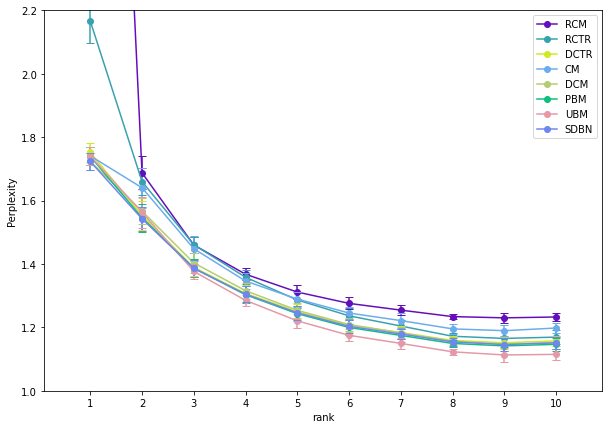

In [162]:
x_axis = range(1, 11)
fig = plt.figure(figsize=(10,7))
for name, list_rank in dict_perp_rank.items():
    plt.plot(x_axis, list_rank, '-o', label=name, color=colors[name])
    plt.bar(x_axis, dict_perp_rank[name], yerr=dict_perprank_boot[name],
            alpha=0, capsize=4, ecolor=colors[name])
plt.ylim(1, 2.2)
plt.xticks(range(1, 11))
plt.xlabel('rank')
plt.ylabel('Perplexity')
plt.legend()
plt.show()

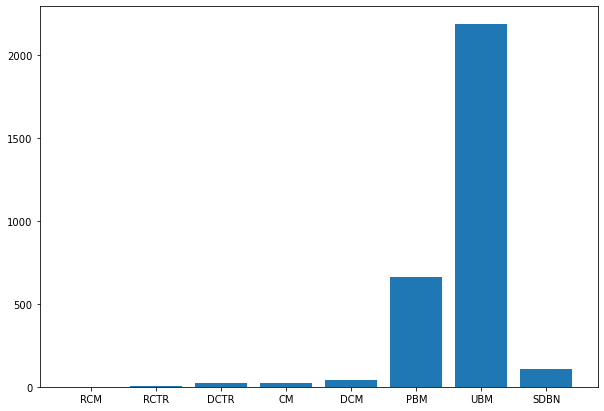

In [165]:
fig = plt.figure(figsize=(10, 7))
plt.bar(pd_parameters['Names'], pd_parameters['Time'])
        #, yerr=list_error, capsize=4)
#plt.title('{} values for different models'.format(title))
#plt.ylabel('{}'.format(title))
plt.show()

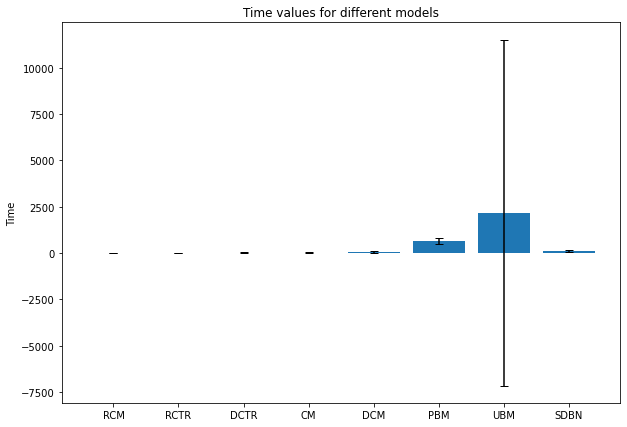

In [146]:
bar_plot(pd_parameters['Time'], list_time_boot, 'Time')

In [151]:
max(list_time_boot)

9336.111571621897

In [152]:
min(list_time_boot)

0.3888893365859985

Because of running problems (the computer went in sleep mode during the execution of UBM) we re-run UBM.

In [168]:
ubm_estimators = parameters_estimation(UBM(), verbose=False) #example

Processing UBM:   0%|          | 0/15 [00:00<?, ?it/s]

In [170]:
pd_parameters.loc[pd_parameters['Names']=='UBM', 'Time']

6    2182.314747
Name: Time, dtype: float64

In [171]:
pd_parameters.loc[pd_parameters['Names']=='UBM', 'Time'] = ubm_estimators['Time'][1]

In [172]:
pd_parameters

,Names,Loglike,Perplexity,Time
0,RCM,-0.421358,1.716669,0.411567
1,RCTR,-0.308236,1.387819,2.110245
2,DCTR,-0.261053,1.310789,22.539181
3,CM,-0.292252,1.351409,21.399894
4,DCM,-0.261508,1.311111,42.377870
5,PBM,-0.254992,1.303039,663.380839
6,UBM,-0.240261,1.286096,812.026098
7,SDBN,-0.255957,1.303559,108.801491


In [173]:
list_time_boot_scaled = list_time_boot[:]

In [174]:
list_time_boot_scaled[-2]

9336.111571621897

In [175]:
take_boot(ubm_estimators['Time'])

181.9154467105866

In [176]:
list_time_boot_scaled[-2]=take_boot(ubm_estimators['Time'])

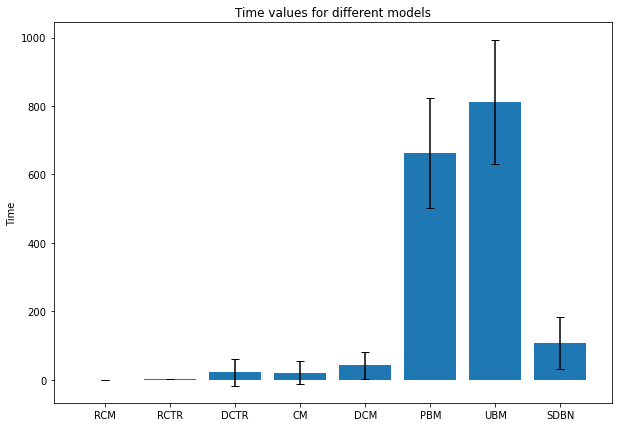

In [177]:
bar_plot(pd_parameters['Time'], list_time_boot_scaled, 'Time')